In [1]:
import mlstac
import torch
import cubo
import sen2sr

In [ ]:
# Download the model
'''
mlstac.download(
  file="https://huggingface.co/tacofoundation/sen2sr/resolve/main/SEN2SRLite/main/mlm.json",
  output_dir=model_dir,
)
'''

In [2]:
model_dir = r"model\sen2sr"

In [3]:
# Load the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = mlstac.load(model_dir).compiled_model(device=device)
model = model.to(device)

In [4]:
# Create a Sentinel-2 L2A data cube for a specific location and date range

da = cubo.create(
    lat=36.680079, 
    lon=10.583995,
    collection="sentinel-2-l2a",
    bands=["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"],
    start_date="2025-04-01",
    end_date="2025-06-05",
    edge_size=1028,
    resolution=10
)

In [ ]:
# Prepare the data to be used in the model, select just one sample 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
original_s2_numpy = (da[1].compute().to_numpy() / 10_000).astype("float32")
X = torch.from_numpy(original_s2_numpy).float().to(device)

In [6]:
# Apply model
superX = sen2sr.predict_large(
    model=model,
    X=X, # The input tensor
    overlap=16, # The overlap between the patches
)

100%|██████████| 100/100 [00:46<00:00,  2.14it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1776..1.1214].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.1669619..1.2157845].


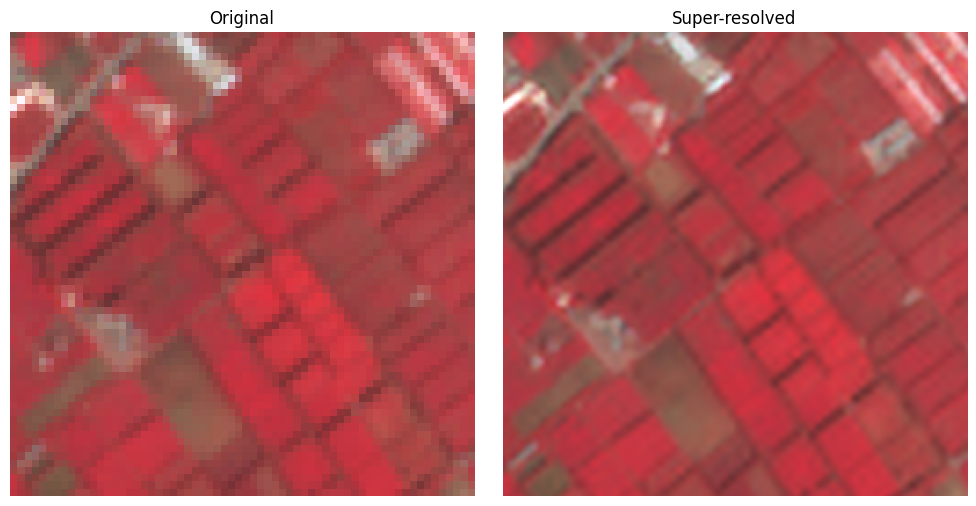

In [7]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

lr = slice(32, 96)
hr = slice(lr.start*4, lr.stop*4)

# Original
axes[0].imshow(X[[6, 2, 1], lr, lr].permute(1, 2, 0).cpu().numpy() * 1.5)
axes[0].set_title("Original")
axes[0].axis('off')

# Mejorada
axes[1].imshow(superX[[6, 2, 1], hr, hr].permute(1, 2, 0).cpu().numpy() * 1.5)
axes[1].set_title("Super-resolved")
axes[1].axis('off')

plt.tight_layout()

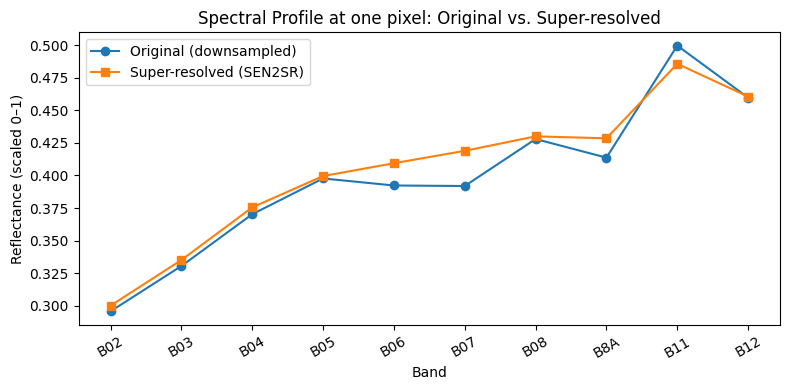

In [ ]:
# doing a spectral check at one pixel

import numpy as np


bands = ["B02", "B03", "B04", "B05", "B06", "B07", "B08", "B8A", "B11", "B12"]

# 1) select the center pixel
_, H, W = X.shape
row_lr, col_lr = H // 2, W // 2


orig_vals = X[:, row_lr, col_lr].cpu().numpy()

# 3) Identify the matching high-res window in superX.
#    If the model is 4× upsampling, then the 2.5 m pixel-block corresponding
#    to (row_lr, col_lr) is roughly rows [row_lr*4 : row_lr*4+4), cols [col_lr*4 : col_lr*4+4).
scale = superX.shape[1] // X.shape[1]  # should be 4 if 10→2.5.
r0, c0 = row_lr * scale, col_lr * scale

# 4) Average the 4×4 block in each band to get one “super-res” spectrum
super_vals = (
    superX[:, r0 : r0 + scale, c0 : c0 + scale]
    .cpu()
    .numpy()
    .reshape(10, scale * scale)
    .mean(axis=1)
)

# 5) Plot them side by side
x = np.arange(len(bands))

plt.figure(figsize=(8, 4))
plt.plot(x, orig_vals, marker="o", label="Original (downsampled)")
plt.plot(x, super_vals, marker="s", label="Super-resolved (SEN2SR)")

plt.xticks(x, bands, rotation=30)
plt.xlabel("Band")
plt.ylabel("Reflectance (scaled 0–1)")
plt.title("Spectral Profile at one pixel: Original vs. Super-resolved")
plt.legend(loc="upper left")
plt.tight_layout()
plt.show()


Pearson correlation per band:
  B02: 0.9978
  B03: 0.9979
  B04: 0.9986
  B05: 0.9298
  B06: 0.9111
  B07: 0.9135
  B08: 0.9983
  B8A: 0.9079
  B11: 0.9174
  B12: 0.9289


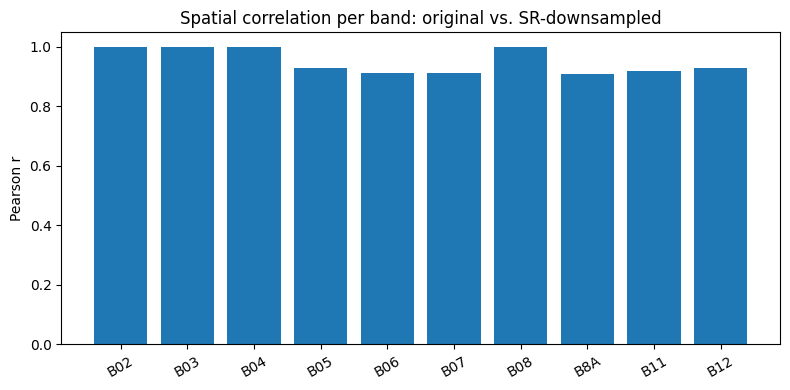

In [ ]:
# Prepare arrays (if not already in scope)
orig = X.cpu().numpy()           # (bands, H, W)
sr   = superX.cpu().numpy()      # (bands, H*scale, W*scale)
bands, H, W = orig.shape
scale = sr.shape[1] // H         # e.g. 4 for 10→2.5 m

# Downsample SR back to 10 m
sr_down = sr.reshape(bands, H, scale, W, scale).mean(axis=(2, 4))

# Compute correlations
corrs = []
for i in range(bands):
    orig_flat = orig[i].ravel()
    sr_flat   = sr_down[i].ravel()
    r = np.corrcoef(orig_flat, sr_flat)[0, 1]
    corrs.append(r)

# Print each band’s coefficient
band_names = ["B02","B03","B04","B05","B06","B07","B08","B8A","B11","B12"]
print("Pearson correlation per band:")
for name, coef in zip(band_names, corrs):
    print(f"  {name}: {coef:.4f}")

# Plot bar chart
plt.figure(figsize=(8, 4))
plt.bar(band_names, corrs)
plt.xticks(rotation=30)
plt.ylabel("Pearson r")
plt.title("Spatial correlation per band: original vs. SR-downsampled")
plt.tight_layout()
plt.show()